# Semantic Segmentation Dataset for Self Driving Cars
https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge

In [8]:
import tensorflow as tf
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.utils import shuffle
%matplotlib inline

# Data Preprocessing

In [10]:
image_paths = []
imseg_paths = []

for x in ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']:
    image_path_dir = 'content/' + x + '/' + x + '/' + 'CameraRGB'
    imseg_path_dir = 'content/' + x + '/' + x + '/' + 'CameraSeg'

    for dirname, _, filenames in os.walk(image_path_dir):        
        for filename in filenames:
            image_path = image_path_dir + '/' + filename
            image_paths.append(image_path)
            imseg_path = imseg_path_dir + '/' + filename
            imseg_paths.append(imseg_path)

            
num_images = len(image_paths)
print("Total number of images = ", num_images)

Total number of images =  5000


In [11]:
def read_image(path):
    image = cv2.imread(path)
    image = image_resize(image)
    return np.array(image)

def read_imseg(path):
    imseg = np.array(cv2.imread(path))
    imseg = image_resize(imseg)
    imseg = np.array([max(imseg[i, j]) for i in range(imseg.shape[0]) for j in range(imseg.shape[1])]).reshape(imseg.shape[0], imseg.shape[1])   
    return imseg

def image_resize(image):
    height, width = (224, 224)
    return np.array(cv2.resize(image, (width, height), cv2.INTER_AREA))

def imseg2roadseg(imseg):
    height, width = imseg.shape
    imseg_road = np.zeros((height, width, 1), dtype=np.int8)
    imseg_road[np.where(imseg==7)[0], np.where(imseg==7)[1]] = 1
    return np.array(imseg_road)

def pipeline(X_path, y_path):
    image_BGR = read_image(X_path)
    imseg = read_imseg(y_path)
    imseg_road = imseg2roadseg(imseg)
    return image_BGR, imseg_road

In [12]:
def read_data(image_paths,imseg_paths):
    height, width = (224, 224)
    images = np.zeros((len(image_paths), height, width, 3), dtype=np.int16)
    imsegs_road = np.zeros((len(image_paths), height, width, 1), dtype=np.int8)
    for index in tqdm(range(len(image_paths))):
        X_path, y_path = image_paths[index], imseg_paths[index]
        images[index], imsegs_road[index] = pipeline(X_path, y_path)
    return images, imsegs_road

X, y = read_data(image_paths,imseg_paths)

100%|██████████| 5000/5000 [08:09<00:00, 10.21it/s]


## Sample Image Visualization

(224, 224, 3)
(224, 224)
(224, 224, 1)


Text(0.5, 1.0, 'Segmented road image')

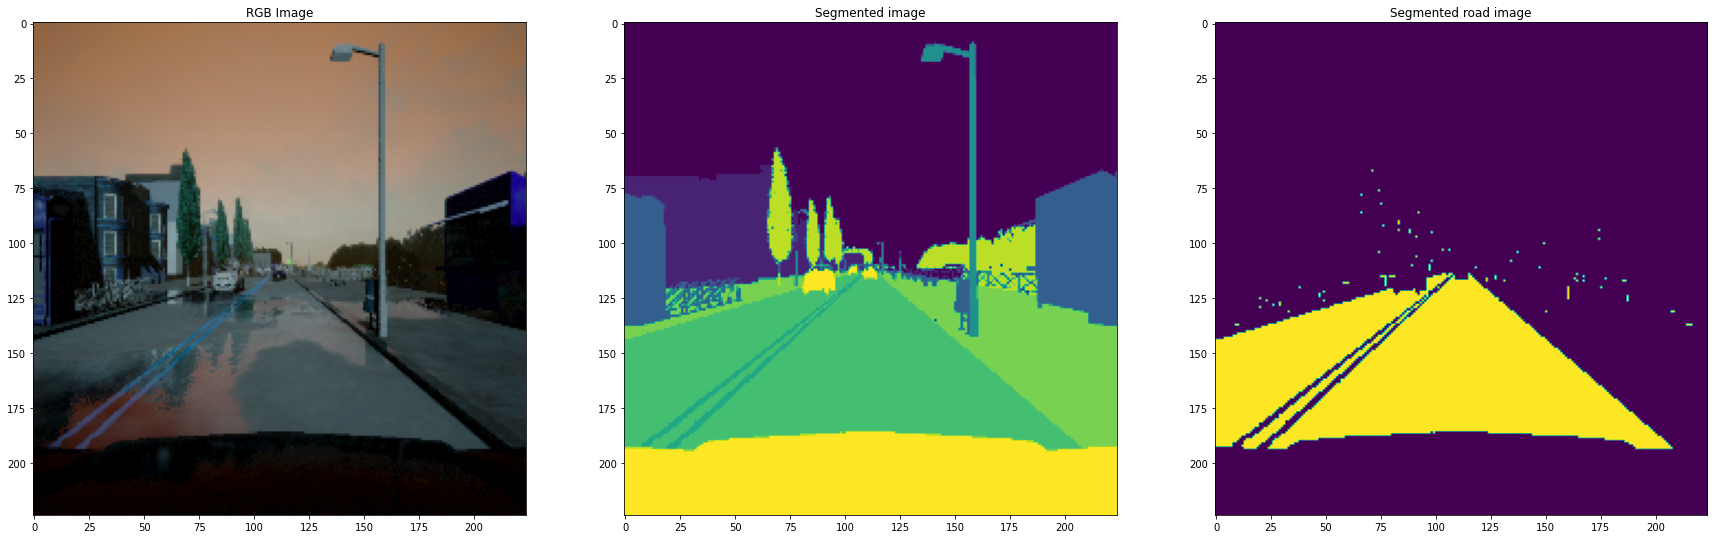

In [13]:
from random import randint
index = randint(0,len(image_paths))
height, width = (224, 224)
segment = 7

image = read_image(image_paths[index])
imseg = read_imseg(imseg_paths[index])
imseg_road = imseg2roadseg(imseg)

print(image.shape)
print(imseg.shape)
print(imseg_road.shape)

fig, axes = plt.subplots(1, 3, figsize=(30,20))
axes[0].imshow(image)
axes[0].set_title('RGB Image')
axes[1].imshow(imseg)
axes[1].set_title('Segmented image')
axes[2].imshow(imseg_road.reshape(height,width))
axes[2].set_title('Segmented road image')

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle =True,  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle =True,  random_state=42)

print("Training images = ", len(X_train), "Validation images= ", len(X_val), "Test images = ", len(X_test))

Training images =  3825 Validation images=  675 Test images =  500


# Implementation of Unet, using Keras

In [15]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [16]:
def encoder_block(input, filters):
  c = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (input)
  c = BatchNormalization()(c)
  c = Dropout(0.1) (c)
  c = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c)
  c = BatchNormalization()(c)
  p = MaxPooling2D((2, 2)) (c)
  return p, c

In [17]:
def bridge_block(input, filters):
  c = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (input)
  c = BatchNormalization()(c)
  c = Dropout(0.3) (c)
  c = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c)
  c = BatchNormalization()(c)
  return c

In [18]:
def decoder_block(input, filters, skip_features):
  u = Conv2DTranspose(filters/2, (2, 2), strides=(2, 2), padding='same') (input)
  u = concatenate([u, skip_features])
  c = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u)
  c = BatchNormalization()(c)
  c = Dropout(0.2) (c)
  c = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c)
  c = BatchNormalization()(c)
  return c

In [19]:
# Build U-Net model
def unet_model(image_shape):
  inputs = Input((image_shape))
  s = Lambda(lambda x: x / 255) (inputs)

  # Encoder 
  p1, c1 = encoder_block(s, 32)
  p2, c2 = encoder_block(p1, 64)
  p3, c3 = encoder_block(p2, 128)
  p4, c4 = encoder_block(p3, 256)

  # Bridge
  c5 = bridge_block(p4, 512)
  
  # Decoder
  c6 = decoder_block(c5, 256, c4)
  c7 = decoder_block(c6, 128, c3)
  c8 = decoder_block(c7, 64, c2)
  c9 = decoder_block(c8, 32, c1)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [20]:
from tensorflow.keras.models import Model
image_shape = (224, 224, 3)
num_classes = 1
model = unet_model(image_shape)

#compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [21]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('unet_model_road_seg_checkpoint.h5', verbose=1, save_best_only=True)

# Training Unet Model

In [22]:
results = model.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=16, epochs=50, verbose=1, callbacks=[earlystopper, checkpointer])

Epoch 1/50
216/216 [==============================] - 93s 260ms/step - loss: 0.1162 - accuracy: 0.9676 - val_loss: 2.8118 - val_accuracy: 0.7783

Epoch 00001: val_loss improved from inf to 2.81176, saving model to unet_model_road_seg_checkpoint.h5
Epoch 2/50
216/216 [==============================] - 55s 256ms/step - loss: 0.0377 - accuracy: 0.9905 - val_loss: 0.0537 - val_accuracy: 0.9867

Epoch 00002: val_loss improved from 2.81176 to 0.05374, saving model to unet_model_road_seg_checkpoint.h5
Epoch 3/50
216/216 [==============================] - 55s 256ms/step - loss: 0.0340 - accuracy: 0.9911 - val_loss: 0.6937 - val_accuracy: 0.9529

Epoch 00003: val_loss did not improve from 0.05374
Epoch 4/50
216/216 [==============================] - 55s 257ms/step - loss: 0.0312 - accuracy: 0.9918 - val_loss: 0.0280 - val_accuracy: 0.9926

Epoch 00004: val_loss improved from 0.05374 to 0.02798, saving model to unet_model_road_seg_checkpoint.h5
Epoch 5/50
216/216 [==============================]

# Visualizing Training Results

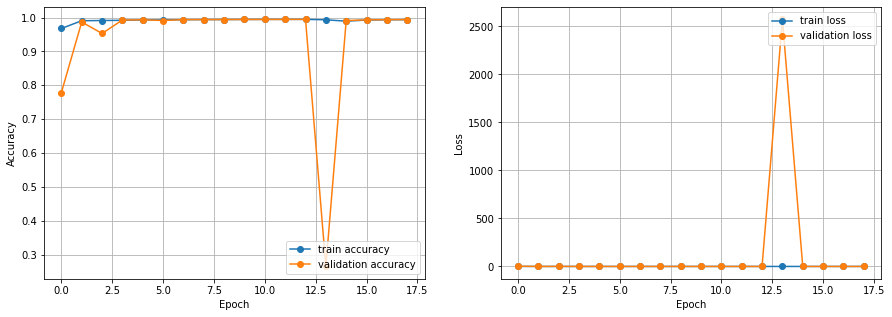

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(results.history['accuracy'], 'o-', label='train accuracy')
plt.plot(results.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(results.history['loss'], 'o-', label='train loss')
plt.plot(results.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

### Testing Unet Model

In [24]:
score = model.evaluate(X_test, y_test, verbose=2, batch_size=16)

32/32 - 3s - loss: 0.0214 - accuracy: 0.9942


# Predicting An Image

Text(0.5, 1.0, 'Ground truth')

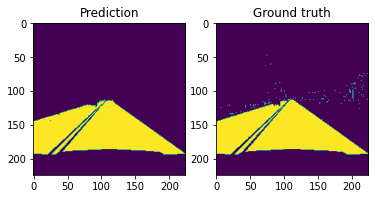

In [25]:
NUMBER = 0

X_test_cast = X_test.astype(float)
y_pred = model.predict(X_test_cast, batch_size=16)
my_preds = y_pred[0].flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(224, 224))
ax[0].set_title('Prediction')
ax[1].imshow(y_test[NUMBER].reshape(224, 224))
ax[1].set_title('Ground truth')

In [26]:
#import tensorflow as tf
#model = tf.keras.models.load_model("unet_model_road_seg_checkpoint.h5")